# Productive Crop Field Contrastive Learning SimCLR Classification

The goal of this notebook is to evaluate the three different methods to predict whether an area is a productive field or not.

## Summary
[1. Data Processing](#data_processing)

[2. Contrastive Learning (SimCLR)](#model_training)

[3. Siamese with Triplet Loss](#siamese_triplet_loss)

[4. Positive Unlabeled Learning](#pu_learning)

[5. Results](#results)

## Load required libraries

In [1]:
import sys

# Install packages required only once
install_packages = False

if install_packages:
    !{sys.executable} -m pip install sklearn
    !{sys.executable} -m pip install seaborn
    !{sys.executable} -m pip install imblearn

In [2]:
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn.objects as so
import seaborn as sns

import pandas as pd
import numpy as np

import h3

## Hyper-parameters and other constants

In [3]:
temporal_samples = 15
band_features = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

width = 30 # output vector size
temperature = 0.5 # empirical temperature value

steps_per_epoch = 10
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5
num_epochs = 20

queue_size = 10000
kernel_size = 3
strides = 1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"jitter": 0.3}
classification_augmentation = {"jitter": 0.1}

<a id='data_processing'></a>

# 1. Data Processing

## 1.1. Load all parquet files from the configured folder

In [4]:
df_positive = pd.read_parquet('df_p.parquet.gzip')
df_negative = pd.read_parquet('df_n.parquet.gzip')

print('The shape of loaded positive dataframe is:', df_positive.shape)
print('The shape of loaded negative dataframe is:', df_negative.shape)

display(df_positive.head(5))
display(df_negative.head(5))

The shape of loaded positive dataframe is: (100430, 14)
The shape of loaded negative dataframe is: (40482, 14)


,timestamp,hex,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12
0,20181029T170421,hex_p_0,527.0,556.0,1080.0,680.0,1532.0,3258.0,3701.0,3692.0,3906.0,3746.0,2627.0,1538.0
1,20181029T170421,hex_p_1,527.0,537.0,1060.0,672.0,1564.0,3248.0,3616.0,3692.0,3899.0,3746.0,2668.0,1605.0
2,20181029T170421,hex_p_2,507.0,625.0,1162.0,861.0,1663.0,3111.0,3434.0,3448.0,3760.0,3892.0,3057.0,1963.0
3,20181029T170421,hex_p_3,507.0,609.0,1112.0,814.0,1638.0,3111.0,3549.0,3536.0,3739.0,3892.0,3037.0,2001.0
4,20181029T170421,hex_p_4,521.0,594.0,1134.0,777.0,1650.0,3168.0,3477.0,3528.0,3804.0,3768.0,2937.0,1876.0


,timestamp,hex,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12
0,20181029T170421,hex_n_0,888.0,1034.0,1458.0,1546.0,1956.0,3277.0,3696.0,4004.0,3844.0,3662.0,3317.0,2241.0
1,20181029T170421,hex_n_1,888.0,934.0,1272.0,1340.0,1669.0,2765.0,3081.0,2800.0,3364.0,3662.0,2883.0,1914.0
2,20181029T170421,hex_n_2,888.0,1042.0,1458.0,1552.0,1903.0,3050.0,3344.0,3124.0,3636.0,3662.0,3379.0,2425.0
3,20181029T170421,hex_n_3,888.0,956.0,1256.0,1370.0,1643.0,2492.0,2738.0,2832.0,3076.0,3662.0,2916.0,2007.0
4,20181029T170421,hex_n_4,760.0,916.0,1368.0,1090.0,1844.0,3406.0,3768.0,4232.0,4069.0,3958.0,3155.0,1978.0


In [5]:
print('In this dataset there are ', df_positive.hex.unique().size, ' different positive hexes')
print('In this dataset there are ', df_negative.hex.unique().size, ' different negative hexes')

In this dataset there are  5066  different positive hexes
In this dataset there are  2050  different negative hexes


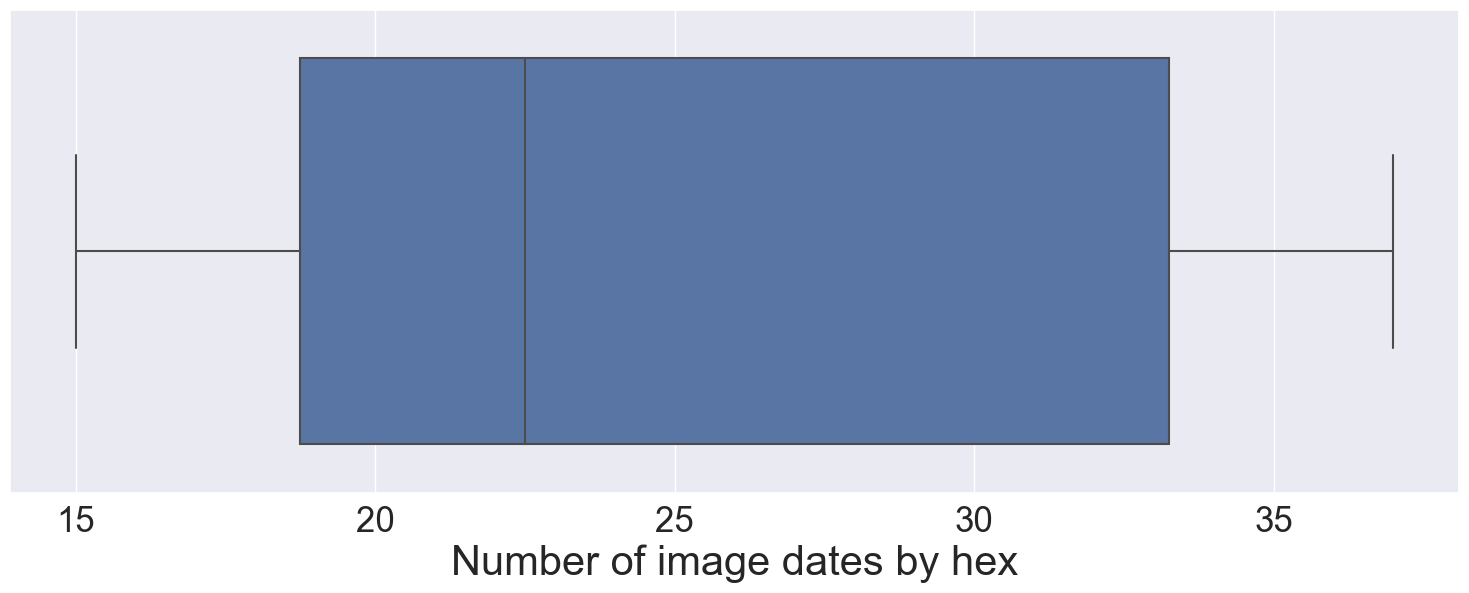

In [6]:
sns.set(rc={'figure.figsize':(18.7,6.27)})

temporal_samples_count = df_positive.groupby(['hex'])['hex'].count()

hist = pd.DataFrame(temporal_samples_count) \
        .rename(columns={'hex': 'count'}) \
        .reset_index(level=0) \
        .groupby(['count'])['count'].count()

hist_df = pd.DataFrame(hist) \
          .rename(columns={'count': 'frequency'}) \
          .reset_index(level=0)

ax = sns.boxplot(x=hist_df["count"])

ax.set_xlabel("Number of image dates by hex",fontsize=30)
ax.tick_params(labelsize=25)

## Sentinel 2 bands
These are the 12 bands contained in the parque files and their respective meanings

<div>
<img src="../res/sentinel2-bands.png" width="500"/>
</div>

## 1.2. Build the bidimensional timeseries samples

In [7]:
shuffle_imgdates = True

number_of_bands = len(band_features)

# Keep only [temporal samples] samples 
df_positive = df_positive.sort_values(by=['hex'])
df_positive = df_positive.groupby('hex').head(temporal_samples)

df_negative = df_negative.sort_values(by=['hex'])
df_negative = df_negative.groupby('hex').head(temporal_samples)

# Associate labels picked manually
df_negative = df_negative.assign(label=0)
df_positive = df_positive.assign(label=1)
df = pd.concat([df_positive, df_negative], axis=0)

display(df)

df = df.reset_index(drop=True)

df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%dT%H%M%S")

print('Number of total rows:' +  str(len(df.index)))
print('Number of rows in dataset (positive/negative): (%s/%s)' % (str(len(df_positive.index)),str(len(df_negative.index))))
print('Number of unique hexes(positive/negative): (%s/%s)' %  (str(df_positive.hex.nunique()), str(df_negative.hex.nunique())))

df[band_features] = StandardScaler().fit_transform(df[band_features])

# Organize the 2D samples in numpy arrays
sample = np.zeros((temporal_samples, number_of_bands), dtype=np.float64)
X_array = np.empty((0, temporal_samples, number_of_bands),  dtype=np.float64)

labels = []
hexes = []
timestamp_tracking = []
timestamp_sample = []

sub_index = 0
count = 0;
for index, row in df.iterrows():
        pct_complete = count/df.shape[0] * 100
        print('Sampling {0:.2f}'.format(pct_complete) + '%', end='\r')
        count = count + 1

        # fill the band values in a temporal row
        for idx,b in enumerate(band_features):
            sample[sub_index][idx] = row[b]

        timestamp_sample.append(row.timestamp)

        # increment row number 
        sub_index = sub_index + 1

        # if reached last row of temporal samples, increment to next sample
        if sub_index == temporal_samples:
            shuffler = np.random.permutation(sample.shape[0])
            sample = sample[shuffler]
            timestamp_sample = list(np.array(timestamp_sample)[shuffler])

            X_array = np.append(X_array, [sample], axis=0)
            labels.append(row.label)
            hexes.append(row.hex)
            timestamp_tracking.append(timestamp_sample.copy())            

            timestamp_sample.clear()
            sub_index = 0

print('Total number of samples: %d samples of %dx%d' % (X_array.shape[0],X_array.shape[1],X_array.shape[2]) )

,timestamp,hex,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,label
0,20181029T170421,hex_p_0,527.0,556.0,1080.0,680.0,1532.0,3258.0,3701.0,3692.0,3906.0,3746.0,2627.0,1538.0,1
69338,20190611T165859,hex_p_0,977.0,836.0,1042.0,924.0,1459.0,2567.0,3134.0,3116.0,3489.0,3365.0,2825.0,1692.0,1
68544,20190601T165859,hex_p_0,1106.0,975.0,1232.0,908.0,1473.0,4137.0,5823.0,5656.0,6130.0,5584.0,2809.0,1446.0,1
3216,20181108T170511,hex_p_0,789.0,703.0,883.0,980.0,1288.0,1458.0,1650.0,1648.0,1865.0,2067.0,3071.0,2579.0,1
64715,20190522T165859,hex_p_0,865.0,754.0,863.0,626.0,1023.0,3087.0,4515.0,4376.0,4705.0,4181.0,2211.0,1020.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55447,20190810T165849,hex_n_999,459.0,373.0,337.0,333.0,447.0,540.0,640.0,634.0,712.0,862.0,708.0,457.0,0
37710,20190122T170619,hex_n_999,525.0,706.0,927.0,880.0,1239.0,2020.0,2432.0,2326.0,2547.0,2050.0,2002.0,1354.0,0
5537,20190308T170131,hex_n_999,1480.0,1220.0,1420.0,1260.0,1781.0,2917.0,3153.0,3130.0,3317.0,1915.0,2160.0,1412.0,0
12623,20190427T165901,hex_n_999,461.0,781.0,984.0,951.0,1388.0,2292.0,2588.0,2734.0,2494.0,2952.0,1983.0,1177.0,0


Number of total rows:106735
Number of rows in dataset (positive/negative): (75990/30745)
Number of unique hexes(positive/negative): (5066/2050)
Total number of samples: 7115 samples of 15x12


In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

## 1.3. Visualize samples in the space

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
model = TSNE(n_components=2, perplexity=4, random_state=0)
tsne_data = model.fit_transform(X_array.reshape(X_array.shape[0], number_of_bands * temporal_samples))
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
tsne_data = pd.concat([tsne_df, pd.DataFrame(labels, columns=['y'])], axis=1)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "y"))

sns.jointplot(data=tsne_df, x="Dim_1", y="Dim_2", hue='y')
plt.show()
warnings.filterwarnings('default')

## 1.4. Visualize the bidimensional timeseries samples

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})

for i in range(0,3):
    # This is what a positive sample looks like
    ax = sns.heatmap(X_array[i], annot=False, cmap="viridis", vmin=-2, vmax=2, 
                     xticklabels=range(1,13), yticklabels=range(1,16), 
                     fmt='g', annot_kws={"fontsize":24}, cbar=True)
    ax.set_xlabel("Band",fontsize=24)
    ax.set_ylabel("Image date",fontsize=24)
    ax.set_title('Sample: ' + hexes[i], fontsize=26)
    ax.tick_params(labelsize=20)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.show()
    


for i in range(-4,-1):  
    ax = sns.heatmap(X_array[i], annot=False, cmap="rocket", vmin=-2, vmax=2, 
                     xticklabels=range(1,13), yticklabels=range(1,16), 
                     fmt='g', annot_kws={"fontsize":20}, cbar=True)
    ax.set_xlabel("Band",fontsize=24)
    ax.set_ylabel("Image date",fontsize=24)
    ax.set_title('Sample: ' + hexes[i], fontsize=26)
    ax.tick_params(labelsize=20)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.show()

## 1.5. Visualize the range of band values

In [ ]:
import pandas as pd
import seaborn as sns

value_vars = [i for i in df.columns if (i.startswith('B') or i.startswith('m'))]
id_vars = ['label']
data = pd.melt(df, id_vars=id_vars, value_vars=value_vars)

sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x="variable", y="value", hue='label', data=data)

## 1.6. Check correlation among bands

In [ ]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap, annot=True )

<a id='model_training'></a>

# 2. Contrastive Learning (SimCLR)

In [ ]:
print('Total of samples:', X_array.shape)

labels_and_hexes = np.vstack((hexes, labels)).T

# 80% for training, 10% test and 10% validation
X_train, X_test, yl_train, yl_test = train_test_split(X_array, labels_and_hexes, test_size=0.2, random_state=42)
X_val, X_test, yl_val, yl_test = train_test_split(X_test, yl_test, test_size=0.5, random_state=42)

labeled_train_samples = X_train.shape[0]
hexes_train, y_train = np.hsplit(yl_train, 2)
hexes_test, y_test = np.hsplit(yl_test, 2)
hexes_val, y_val = np.hsplit(yl_val, 2)

y_val = np.array(y_val).T[0]
y_test = np.array(y_test).T[0]
y_train = np.array(y_train).T[0]
hexes_val = np.array(hexes_val).T[0]
hexes_test = np.array(hexes_test).T[0]
hexes_train = np.array(hexes_train).T[0]

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)
y_val = y_val.astype(np.int)

print('Total of training samples:',X_train.shape, len(y_train))
print('Total of test samples:', X_test.shape, len(y_test))
print('Total of validation samples:', X_val.shape, len(y_val))


In [ ]:
def prepare_dataset():
    labeled_batch_size = labeled_train_samples // steps_per_epoch
    batch_size = labeled_batch_size
 
    train_dataset = tf.data.Dataset\
        .from_tensor_slices((X_train, y_train))\
        .shuffle(buffer_size=10 * labeled_batch_size)\
        .batch(labeled_batch_size)
    
    test_dataset = tf.data.Dataset\
        .from_tensor_slices((X_test, y_test))\
        .batch(batch_size)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    
    validation_dataset = tf.data.Dataset\
        .from_tensor_slices((X_val, y_val))\
        .batch(5)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    
    full_dataset = tf.data.Dataset\
        .from_tensor_slices((X_array, labels))\
        .batch(5)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)

    return batch_size, train_dataset, test_dataset, validation_dataset, full_dataset

    
    
batch_size, train_dataset, test_dataset, validation_dataset, full_dataset = prepare_dataset()

In [ ]:
# Distorts the color distibutions of images
class RandomAugmentSatelliteBands(layers.Layer):
    def __init__(self, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]
            
            
            # jitter colors
            #jitter_matrices = tf.random.uniform(
            #    (batch_size, temporal_samples, 1), minval=1 - self.jitter, maxval=1 + self.jitter
            #)
            
            jitter_matrices = tf.random.uniform(
                (batch_size, temporal_samples, 1), minval=1.3, maxval=1.3
            )
            
            jitter_matrices = tf.concat([jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,
                                         jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,
                                         jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices], axis=2)
            
            
            
            images = tf.round(images * jitter_matrices)
            
            # shuffle dates
            #images = tf.random.shuffle(tf.transpose(images, [1, 0, 2]))
            #images = tf.transpose(images, [1, 0, 2])
            
            
        return images

# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(temporal_samples, number_of_bands)),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

# Image augmentation module
def get_augmenter(jitter):
    return keras.Sequential(
        [
            keras.Input(shape=(temporal_samples, number_of_bands)),
            RandomAugmentSatelliteBands(jitter),
        ]
    )


In [ ]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][:num_images]

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.5, 4 * 2.5), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=4)

In [ ]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

In [ ]:
# Define the contrastive model with model-subclassing

class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()

        
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(1, activation='sigmoid')], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.BinaryCrossentropy(from_logits=False)
        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.BinaryAccuracy(name="c_acc")
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.BinaryAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )        

        # The similarity between the representations of two augmented views of the
        # same hex should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
    
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(contrastive_labels, tf.transpose(similarities))

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.binary_crossentropy(
            contrastive_labels, similarities, from_logits=False
        )
        
        loss_2_1 = keras.losses.binary_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=False
        )
        
        
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = labeled_images
        
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()

pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=True
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=train_dataset
)


print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

# Encoding a few samples

In [ ]:
# Encoder for validation
encoder_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
    ],
    name="encoder_model",
)

encoded_vectors = encoder_model.predict(X_val)

print(encoded_vectors.shape)


# Visualization of the encoded samples in the XY space

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(encoded_vectors)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))

tsne_df = pd.concat([tsne_df, pd.DataFrame(y_val, columns=['y'])], axis=1)

sns.jointplot(data=tsne_df, x="Dim_1", y="Dim_2", hue='y')
plt.show()
warnings.filterwarnings('default')

## Finetuning model

In [ ]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(1, activation='sigmoid'),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

In [ ]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

<a id='siamese_triplet_loss'></a>

# 3. Siamese Triplet Loss

In [ ]:
X_array_n = X_array[np.array(labels) == 0]
X_array_p = X_array[np.array(labels) == 1]

from sklearn.model_selection import train_test_split

print('Total of samples:', X_array.shape)

labels_and_hexes = np.vstack((hexes, labels)).T

X_array_anchors = X_array_p[0:math.floor((X_array_p.shape[0]/2))]
X_array_positives = X_array_p[math.floor(X_array_p.shape[0]/2):-1]
X_array_negatives = X_array_n[0:math.floor((X_array_p.shape[0]/2))]

print('Total of anchors samples:', X_array_anchors.shape)
print('Total of positive samples:', X_array_positives.shape)
print('Total of negative samples:', X_array_negatives.shape)

samples_count = X_array_anchors.shape[0]
print('Number of samples:', samples_count)

In [ ]:
def prepare_dataset():
    anchor_dataset = tf.data.Dataset\
        .from_tensor_slices(X_array_anchors)

    positive_dataset = tf.data.Dataset\
        .from_tensor_slices(X_array_positives)
    
    negative_dataset = tf.data.Dataset\
        .from_tensor_slices(X_array_negatives)
    
    return anchor_dataset, positive_dataset, negative_dataset
   
anchor_dataset, positive_dataset, negative_dataset = prepare_dataset()
print(anchor_dataset, positive_dataset, negative_dataset)


dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=128)

# Let's now split our dataset in train and validation.
siamese_train_dataset = dataset.take(round(samples_count * 0.8))
siamese_train_dataset = siamese_train_dataset.batch(32, drop_remainder=False)

siamese_validation_dataset = dataset.skip(round(samples_count * 0.8))
siamese_validation_dataset = siamese_validation_dataset.batch(32, drop_remainder=False)

In [ ]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(temporal_samples, number_of_bands)),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

embedding = get_encoder()

In [ ]:
from tensorflow.keras import Model

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=(15,12))
positive_input = layers.Input(name="positive", shape=(15,12))
negative_input = layers.Input(name="negative", shape=(15,12))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=keras.optimizers.Adam(0.0001))
siamese_model.fit(siamese_train_dataset, epochs=50, validation_data=siamese_validation_dataset)

In [ ]:
sample = next(iter(siamese_train_dataset))

anchor, positive, negative = sample

anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

cosine_similarity = keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

posneg_similarity = cosine_similarity(positive_embedding, negative_embedding)
print("PosNeg similarity", posneg_similarity.numpy())

In [ ]:
from sklearn.model_selection import train_test_split

print('Total of samples:', X_array.shape)

labels_and_hexes = np.vstack((hexes, labels)).T

# 80% for training, 10% test and 10% validation
X_train, X_test, yl_train, yl_test = train_test_split(X_array, labels_and_hexes, test_size=0.2, random_state=42)
X_val, X_test, yl_val, yl_test = train_test_split(X_test, yl_test, test_size=0.5, random_state=42)

labeled_train_samples = X_train.shape[0]
hexes_train, y_train = np.hsplit(yl_train, 2)
hexes_test, y_test = np.hsplit(yl_test, 2)
hexes_val, y_val = np.hsplit(yl_val, 2)

y_val = np.array(y_val).T[0]
y_test = np.array(y_test).T[0]
y_train = np.array(y_train).T[0]
hexes_val = np.array(hexes_val).T[0]
hexes_test = np.array(hexes_test).T[0]
hexes_train = np.array(hexes_train).T[0]

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)
y_val = y_val.astype(np.int)

print('Total of training samples:',X_train.shape, len(y_train))
print('Total of test samples:', X_test.shape, len(y_test))
print('Total of validation samples:', X_val.shape, len(y_val))

In [ ]:
# Supervised finetuning of the pretrained encoder
finetuning_siamese_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_encoder(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="finetuning_model",
)
finetuning_siamese_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

finetuning_siamese_history = finetuning_siamese_model.fit(
    train_dataset, epochs=num_epochs * 10 , validation_data=validation_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_siamese_history.history["val_acc"]) * 100
    )
)

<a id='pu_learning'></a>

# 4. Positive Unlabeled Learning

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_reshaped, y_train)
h_rus = hexes_train[rus.sample_indices_]

print(X_rus.shape, np.array(y_rus).shape, np.array(h_rus).shape)

print(sum(np.array(y_train)==0),sum(np.array(y_train)==1))
print(sum(np.array(y_rus)==0),sum(np.array(y_rus)==1))

In [ ]:
import baggingPU
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

bc = baggingPU.BaggingClassifierPU(SVC(gamma='auto'), 
                         n_estimators = 50, 
                         n_jobs = -1, 
                         max_samples = sum(y_rus)  # Each training sample will be balanced 
                        )
bc.fit(X_rus, y_rus)




<a id='results'></a>

# 5. Results Summary

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_pred = baseline_model.predict(validation_dataset)
baseline_result = np.where(baseline_pred > 0.5, 1, 0)
print('Baseline Accuracy: {:.2f}%'.format(accuracy_score(y_val, baseline_result) * 100))
print('Baseline Recall: {:.2f}%'.format(recall_score(y_val, baseline_result) * 100))
print('Baseline Precision: {:.2f}%'.format(precision_score(y_val, baseline_result) * 100))
print('Baseline F1: {:.2f}%'.format(f1_score(y_val, baseline_result) * 100))
m = confusion_matrix(y_val, baseline_result)
print('Baseline Acc by Class', (m.diagonal()/m.sum(axis=1)))
print(confusion_matrix(y_val, baseline_result))

simclr_output = finetuning_model.predict(validation_dataset)
simclr_result = np.where(simclr_output > 0.5, 1, 0)

print('Contrastive Accuracy: {:.2f}%'.format(accuracy_score(y_val, simclr_result) * 100))
print('Contrastive Recall: {:.2f}%'.format(recall_score(y_val, simclr_result) * 100))
print('Contrastive Precision: {:.2f}%'.format(precision_score(y_val, simclr_result) * 100))
print('Contrastive F1: {:.2f}%'.format(f1_score(y_val, simclr_result) * 100))
m = confusion_matrix(y_val, simclr_result)
print('Contrastive Acc by Class', (m.diagonal()/m.sum(axis=1)))
print(confusion_matrix(y_val, simclr_result))

siamese_output = finetuning_siamese_model.predict(validation_dataset)
siamese_result = np.where(siamese_output > 0.5, 1, 0)

print('Triplet Loss Accuracy: {:.2f}%'.format(accuracy_score(y_val, siamese_result) * 100))
print('Triplet Loss Recall: {:.2f}%'.format(recall_score(y_val, siamese_result) * 100))
print('Triplet Loss Precision: {:.2f}%'.format(precision_score(y_val, siamese_result) * 100))
print('Triplet Loss F1: {:.2f}%'.format(f1_score(y_val, siamese_result) * 100))
m = confusion_matrix(y_val, siamese_result)
print('Triplet Loss Acc by Class', (m.diagonal()/m.sum(axis=1)))
print(confusion_matrix(y_val, siamese_result))

pu_result = bc.predict(X_val_reshaped)

print('Validation Dataset')
print('Precision: ', precision_score(y_val, pu_result))
print('Recall: ', recall_score(y_val, pu_result))
print('Accuracy: ', accuracy_score(y_val, pu_result))
print('F1: ', f1_score(y_val, pu_result))
m = confusion_matrix(y_val, pu_result)
print('F1 Acc by Class', (m.diagonal()/m.sum(axis=1)))
print(confusion_matrix(y_val, pu_result))


print('-------- Support to fill the table in the research paper --------')

print(
      '%.2f'  % (float(accuracy_score(y_val, baseline_result))*100) + '\\%&',
      '%.2f' % float(f1_score(y_val, baseline_result, average='weighted')*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, baseline_result, average=None)[0]*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, baseline_result, average=None)[1]*100)+ '\\%&',
      '%.2f' % matthews_corrcoef(y_val, baseline_result) + '\\\\',
     )

print(
      '%.2f'  % (float(accuracy_score(y_val, pu_result))*100) + '\\%&',
      '%.2f' % float(f1_score(y_val, pu_result, average='weighted')*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, pu_result, average=None)[0]*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, pu_result, average=None)[1]*100)+ '\\%&',
      '%.2f' % matthews_corrcoef(y_val, pu_result) + '\\\\',
     )

print(
      '%.2f'  % (float(accuracy_score(y_val, simclr_result))*100) + '\\%&',
      '%.2f' % float(f1_score(y_val, simclr_result, average='weighted')*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, simclr_result, average=None)[0]*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, simclr_result, average=None)[1]*100)+ '\\%&',
      '%.2f' % matthews_corrcoef(y_val, simclr_result) + '\\\\',
     )

print(
      '%.2f'  % (float(accuracy_score(y_val, siamese_result))*100) + '\\%&',
      '%.2f' % float(f1_score(y_val, siamese_result, average='weighted')*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, siamese_result, average=None)[0]*100)+ '\\%&',
      '%.2f' % float(f1_score(y_val, siamese_result, average=None)[1]*100)+ '\\%&',
      '%.2f' % matthews_corrcoef(y_val, siamese_result) + '\\\\',
     )

# End of Notebook